In [1]:
import sys
sys.path.append('../scripts')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import re

from xl_bel.linkers import NGramKBLinker, SapBERTLinker
from xl_bel.el_datasets import load_distemist_linking
from xl_bel.util import clean_concepts_from_dataset
from xl_bel.evaluation import evaluate, entity_linking_error_analysis
import distemist_util

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
debug = False

In [5]:
dict_path = Path('../dicts')

In [6]:
kb = pickle.load(open(dict_path / 'umls_full_distemist_3grams_filter_snomed' / 'kb.pickle', 'rb'))

In [7]:
with open('../test_docs.txt', 'r') as fh:
    test_ids = [l.strip() for l in fh.readlines()]
    
ds = load_distemist_linking()["train"]

X = ds.filter(lambda r: r['document_id'] not in test_ids)
X_valid = ds.filter(lambda r: r['document_id'] in test_ids)

Reusing dataset dis_temist (/home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-d8f1bae31511e7eb.arrow
Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-8583e7997e380dcd.arrow


In [8]:
# Set to True to recommpute the suppression status index, otherwise load from disk
calc_suppress = False

In [9]:
from scispacy.umls_utils import read_umls_file_headers

if calc_suppress:
    META_PATH = Path('/home/Florian.Borchert/umls/2021AB/META/')
    mr_conso_path = META_PATH / 'MRCONSO.RRF'
    mr_conso = pd.read_csv(mr_conso_path, sep='|', dtype='str')
    mr_conso.columns = read_umls_file_headers(META_PATH, "MRCONSO.RRF")
    mr_conso.set_index('CUI', inplace=True)
    snomed_index = mr_conso[mr_conso.SAB.isin(['SCTSPA', 'SNOMEDCT_US'])].set_index('SCUI')

    suppress_ratios = {}
    for concept_id in tqdm(kb.cui_to_entity.keys()):
        if not concept_id in snomed_index.index:
            print("Warn, skipping:", concept_id)
            suppress_ratio = 0.0
        else:    
            matches = snomed_index.loc[concept_id]
            suppress_ratio = (matches.SUPPRESS != 'N').sum() / len(matches)
        suppress_ratios[concept_id] = suppress_ratio
        
    with open('../dicts/suppress.pkl', 'wb') as fh:
        pickle.dump(suppress_ratios, fh)
        
else:
    with open('../dicts/suppress.pkl', 'rb') as fh:
        suppress_ratios = pickle.load(fh)

In [10]:
def add_ngram_linker(linkers, dict_name : str, threshold, k : int, key : str = None):
    cg = NGramKBLinker.load_candidate_generator(dict_path / dict_name)
    linker = NGramKBLinker(
        candidate_generator=cg, 
        threshold=threshold,
        filter_for_definitions=False,
        k=k
    )
    if not key:
        key = f'ngram_{dict_name}_{threshold}_{k}'
    linkers[key] = lambda: linker

In [11]:
from xl_bel.linkers.sapbert.sap_bert_linker import _SAP_BERT_XLMR

def add_sap_bert_linker(linkers, model : str, threshold, k : int, embedding_model_name=_SAP_BERT_XLMR, consider_ngrams=[], key : str = None):
    def linker_fn():
        SapBERTLinker.clear()
        if debug:
            print(f"Initializing SapBERT linker for dictionary {model}")
        term_dict_pkl = dict_path / model / 'dict.pickle'
        embed_pkl = dict_path / model / 'embed.pickle'

        return SapBERTLinker(term_dict_pkl, embed_pkl, k=k, cuda=True, threshold=threshold, embedding_model_name=embedding_model_name, consider_n_grams=consider_ngrams)

    if not key:
        key = f'sap_{model}_{threshold}_{consider_ngrams if consider_ngrams else "no_ngrams"}_{k}'
    linkers[key] = linker_fn

# Evaluation

In [12]:
_default_thresholds = [0.0, 0.2, 0.5, 0.7, 0.8, 0.9, 0.99]
_default_ks = [1,2,3,5,10,20]

def eval_thresholds(dataset, pred, thresholds, ks, pbar=None):
    all_eval = {}
    
    steps = len(thresholds) * len(ks)
    
    if not pbar:
        pbar = tqdm(total=steps)
    for threshold in thresholds:
        all_eval[threshold] = {}
        for k in ks:
            eval = evaluate(dataset, pred, allow_multiple_gold_candidates=False, top_k_predictions=k, threshold=threshold)
            all_eval[threshold][f'f1@{k}'] = eval['strict']['fscore']
            all_eval[threshold][f'p@{k}'] = eval['strict']['precision']
            all_eval[threshold][f'r@{k}'] = eval['strict']['recall']
            pbar.update(1)
    return all_eval

def run_eval(dataset, preds, all_tresholds = True, thresholds=_default_thresholds, ks=_default_ks):
    evals = []
    error_dfs = []
    
    if all_tresholds:
        steps = len(thresholds) * len(ks) * len(preds)
    else:
        steps = len(preds)

    with tqdm(total=steps) as pbar:
        for pred in preds:
            if all_tresholds:
                all_eval = eval_thresholds(dataset, pred, thresholds, ks, pbar)
                evals.append(all_eval)

            error_df = entity_linking_error_analysis(dataset, pred)
            error_dfs.append(error_df)
    return evals, error_dfs

In [13]:
def get_type(c):
    return [t for t in kb.cui_to_entity[c].types if t[0] != 'T'][0] if c in kb.cui_to_entity else 'None'

In [14]:
def merge_errors_dfs(linkers, error_dfs, simple=True):
    dfs = []
    for name, edf in zip(linkers.keys(), error_dfs):            
        edf['pred_top_type'] = edf.pred_top.map(get_type)        
        df = edf.rename(columns=lambda c: f"{c}_{name}")
        dfs.append(df)
    res = pd.concat(dfs, axis=1)
    res = res.loc[:,~res.columns.duplicated()]
    res['true_type'] = error_dfs[0].gold_concept.map(get_type)
    res['true_concept'] = error_dfs[0].gold_concept
    res['true_name'] = error_dfs[0].gt_text
    index_cols =  [c for c in res.columns if re.match(r'pred_index_(?!score).*', c)]
    res['best_prediction_index'] = res[index_cols].apply(lambda r: r.values[r.values != -1].min() if (r.values != -1).any() else -1, axis=1)
    output_cols = [c for c in res.columns if c.startswith('true') or c.startswith('best')] + [c for c in res.columns if c.startswith('pred_index') or (not simple and c.startswith('pred_top'))]
    return res[output_cols]

In [15]:
pd.options.display.float_format = '{:,.3f}'.format

def merge_eval_df(linkers, evals):
    eval_df = []
    for e, l in zip(evals, linkers.keys()):
        for t, res in e.items():
            res['threshold'] = t
            res['linker'] = l
            eval_df.append(res)
    eval_df = pd.DataFrame(eval_df)
    eval_df.set_index(['linker', 'threshold'], inplace=True)
    return eval_df

In [16]:
from xl_bel.reranking.rule_based import RuleBasedReranker

def individual_concept_scorer(rule, **kwargs):
    def fn(concepts, ctx):
        scores = []
        for rank, data in enumerate(zip(concepts['concept_id'], concepts['score'])):
            cid, score = data
            ctx.rank = rank    
            scores.append(rule(cid, score, ctx, **kwargs))
        concepts['score'] = scores
        return concepts
    return fn
    
def combined_scorer(beta : float):
    def fn(concepts, ctx):
        counts = {k:v for k,v in zip(*np.unique(concepts['concept_id'], return_counts=True))}
        return individual_concept_scorer(lambda cid, s, _: s * 1 + beta * counts[cid])(concepts, ctx)
    return fn

def score_by_type_disorder(concept_id, score, ctx, cutoff, factor):    
    types = kb.cui_to_entity[concept_id].types
    if ctx.rank < cutoff and 'disorder' in types:        
        return score * factor
    return score

def score_by_type_finding(concept_id, score, ctx, cutoff, factor):    
    types = kb.cui_to_entity[concept_id].types
    if ctx.rank < cutoff and 'finding' in types:        
        return score * factor
    return score

def score_by_type_morph(concept_id, score, ctx, cutoff, factor):    
    types = kb.cui_to_entity[concept_id].types
    if ctx.rank < cutoff and 'morphologic abnormality' in types:        
        return score * factor
    return score

def score_by_type_qualifier(concept_id, score, ctx, cutoff, factor):    
    types = kb.cui_to_entity[concept_id].types
    if ctx.rank < cutoff and 'qualifier value' in types:        
        return score * factor
    return score

def score_by_type_body(concept_id, score, ctx, cutoff, factor):    
    types = kb.cui_to_entity[concept_id].types
    if ctx.rank < cutoff and 'body structure' in types:        
        return score * factor
    return score

def score_umls_suppression(concept_id, score, ctx, factor):
    if not concept_id in suppress_ratios:
        return score
    return score + factor * suppress_ratios[concept_id]

def score_preferred_term(concept_id, score, ctx, factor):
    item = kb.cui_to_entity[concept_id] 
    if item.canonical_name == ctx.entity_text:
        return score * factor
    return score

#### Mapping of concept IDs text mentions in the training data

In [17]:
text2concept = []

for x in X:
    for t, c in zip(x['entities']['text'], x['entities']['concepts']):
        text2concept.append({'text' : t, 'concept_id': c['concept_id'][0]})
idx = pd.DataFrame(text2concept).value_counts()

idx

text                                 concept_id
lesión                               417163006     122
lesiones                             157670007      43
hipertensión arterial                38341003       40
tumor                                55342001       25
fumador                              77176002       24
                                                  ... 
enfermedad profesional               115966001       1
enfermedad protrombótica y vascular  76612001        1
enfermedad renal crónica severa      709044004       1
enfermedad sistémica                 56019007        1
útero miomatoso con calcificaciones  95315005        1
Length: 2865, dtype: int64

In [18]:
# Any ambiguous text - concept mapping? -> Not in the training data
idx.index.levels[0].duplicated().sum()

0

### Utility function for training set lookup

In [19]:
# Reuse concepts in the training data if text matches exactly
def post_process_linking(ds):
    entities = ds['entities'].copy()
    for i, t in enumerate(entities['text']):
        c = entities['concepts'][i]
        if t in [i[0] for i in idx.index]:
            gt = idx.loc[t, :].index[0]
            if len(c['concept_id']) == 0:
                c['concept_id'].append(gt)
                c['predicted_by'].append('manual')
                c['target_kb'].append('UMLS')
                c['type'].append(None)
                c['score'].append(1.0)
            if c['concept_id'][0] != gt:
                c['concept_id'][0] = gt
    return { 'entities' : entities }

In [20]:
from xl_bel.linkers.ensemble import EnsembleLinker

def run_linkers(dataset, config, ground_truth=None, do_rerank=True):
    
    if not ground_truth:
        ground_truth = dataset

    linkers = {}
    weights = {}
    thresholds = {}

    top_k = 100
    batch_size = 128 * 5

    preds = []
    output = {}

    add_ngram_linker(linkers, 'distemist_3grams', threshold=0.0, k=top_k, key='ngrams')
    add_sap_bert_linker(linkers, 'sapbert_umls_full_distemist_filter_snomed', threshold=0.0, k=top_k, key='sap_umls')

    for k, linker_fn in linkers.items():
        linker = linker_fn()
        pred = linker.predict_batch(clean_concepts_from_dataset(dataset), batch_size=batch_size)

        output[k] = pred
        print(k)
        if debug:
            print(evaluate(ground_truth, pred, allow_multiple_gold_candidates=False, top_k_predictions=1)['strict'])

        preds.append(pred)

    _, error_dfs = run_eval(ground_truth, preds, all_tresholds=False)

    o = merge_errors_dfs(linkers, error_dfs, simple=False)
    cols = [c for c in o.columns if re.match(r'pred_index_(?!score).*', c)]

    if debug:
        for i in range(len(cols), 0, -1):
            ss_cols = cols[0:i]
            errors_subset = o[ss_cols]
            print(ss_cols)
            idx = errors_subset.apply(lambda r: r.values[r.values >= 0].min() if (r.values >= 0).any() else -1, axis=1)
            counts = idx.value_counts()
            print(counts[0:5])
            print('R@1', counts[0] / len(errors_subset))
            #print('R@2', (counts[0] + counts[2]) / len(errors_subset))

    reuse_preds = {}

    for linker_name, pred in zip(linkers.keys(), preds):
        reuse_preds[linker_name] = pred

    reuse_preds['ngrams'] = EnsembleLinker.filter_and_apply_threshold(reuse_preds['ngrams'], config['k_ngrams'], config['threshold_ngrams'])
    reuse_preds['sap_umls'] = EnsembleLinker.filter_and_apply_threshold(reuse_preds['sap_umls'], config['k_sap_umls'], config['threshold_sap_umls'])

    if len(linkers) > 1:       
        
        weights = {
            'ngrams' : config['weight_ngrams'],
            'sap_umls' : config['weight_sap_umls'],
        }
        
        e = EnsembleLinker(linkers=linkers, candidates_per_linker={}, linker_weights=weights, linker_thresholds={})

        e_pred = e.predict_batch(clean_concepts_from_dataset(dataset), batch_size=batch_size, reuse_preds=reuse_preds)
        output['ensemble'] = e_pred
        print('>>> Ensemble')
        if debug:
            print(evaluate(ground_truth, e_pred, allow_multiple_gold_candidates=False, top_k_predictions=1)['strict'])

        if do_rerank:
            rr = RuleBasedReranker([
                individual_concept_scorer(score_by_type_disorder, cutoff=10, factor=config['factor_disorder']),
                individual_concept_scorer(score_by_type_finding, cutoff=10, factor=config['factor_finding']),
                individual_concept_scorer(score_by_type_morph, cutoff=10, factor=config['factor_morph']),
                #individual_concept_scorer(score_by_type_qualifier, cutoff=10, factor=reranking_config['factor_qualifier']),
                #individual_concept_scorer(score_by_type_body, cutoff=10, factor=reranking_config['factor_body']),
                individual_concept_scorer(score_preferred_term, factor=config['factor_preferred']),
                individual_concept_scorer(score_umls_suppression, factor=config['factor_umls_suppression']),
                combined_scorer(beta=config['beta'])
            ])
            e_rr_pred = rr.rerank_batch(e_pred)
            output['ensemble_reranked'] = e_rr_pred
            print('>>> Ensemble (reranked)')
            if debug:
                print(evaluate(ground_truth, e_rr_pred, allow_multiple_gold_candidates=False, top_k_predictions=1)['strict'])
            print('\nDone !')
            
            e_rr_pred_post_process = e_rr_pred.map(post_process_linking)
            output['ensemble_reranked_post_process'] = e_rr_pred_post_process
            print('>>> Ensemble (reranked) post processed')
            if debug:
                print(evaluate(ground_truth, e_rr_pred_post_process, allow_multiple_gold_candidates=False, top_k_predictions=1)['strict'])
            print('\nDone !')
    return output

### Optimal config settings

In [21]:
ensemble_config = {
 'k_ngrams': 100,
 'k_sap_umls': 100,
 'weight_ngrams': 0.6504051838658051,
 'weight_sap_umls': 0.6238908394984983,
 'threshold_ngrams': 0.6783871010249929,
 'threshold_sap_umls': 0.7529960339856937
}

reranking_config = { 
 'k_ngrams': 1,
 'k_sap_umls': 4,
 'weight_ngrams': ensemble_config['weight_ngrams'],
 'weight_sap_umls': ensemble_config['weight_sap_umls'],
 'threshold_ngrams': ensemble_config['threshold_ngrams'],
 'threshold_sap_umls': ensemble_config['threshold_sap_umls'],
 'beta': 0.3542986616954429,
 'factor_morph': 0.010715928257092444,
 'factor_finding': 1.3889020502584597,
 'factor_disorder': 1.1379672924904702,
 'factor_preferred': 1.0491444606185638,
 'factor_umls_suppression': -1.1911262691013396
}

In [22]:
import warnings

def run_all_linkers(dataset, ground_truth=None):    
    if ground_truth == None:
        ground_truth = dataset
    scores = []
    predictions = {}
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")    
        out_ensemble_1 = run_linkers(dataset, ensemble_config, ground_truth, do_rerank=False)
        out_reranking_consecutive = run_linkers(dataset, reranking_config, ground_truth)
    
    def get_score(out, key, name):
        res = evaluate(ground_truth, out[key], allow_multiple_gold_candidates=False, top_k_predictions=1)
        return {
            'name' : name,
            'p_loose' : res['partial']['precision'],
            'r_loose' : res['partial']['recall'],
            'f1_loose' : res['partial']['fscore'],
            'p_strict' : res['strict']['precision'],
            'r_strict' : res['strict']['recall'],
            'f1_strict' : res['strict']['fscore'],
        }
    
    scores.append(get_score(out_ensemble_1, 'ngrams', 'n-grams (DisTEMIST)'))
    predictions['ngrams'] = out_ensemble_1['ngrams']
    
    scores.append(get_score(out_ensemble_1, 'sap_umls', 'sapBERT (DisTEMIST + UMLS)'))
    predictions['sap_umls'] = out_ensemble_1['sap_umls']
    
    scores.append(get_score(out_ensemble_1, 'ensemble', 'Ensemble'))
    predictions['ensemble'] = out_ensemble_1['ensemble']
    
    scores.append(get_score(out_reranking_consecutive, 'ensemble_reranked', 'Ensemble + Reranking'))
    predictions['ensemble_reranked'] = out_reranking_consecutive['ensemble_reranked']
    
    scores.append(get_score(out_reranking_consecutive, 'ensemble_reranked_post_process', 'Ensemble + Reranking + Post-Processing'))
    predictions['ensemble_reranked_post_process'] = out_reranking_consecutive['ensemble_reranked_post_process']
    
    return pd.DataFrame(scores).set_index('name'), predictions
    

## Predictions and statistics for the paper

### Dictionaries

#### DisTemist dictionary

In [23]:
dist = pd.read_csv('../dicts/dictionary_distemist.tsv', sep='\t')
len(dist.code.unique()), len(dist)

(111179, 147280)

#### Multilingual UMLS dictionary

In [24]:
with open('../dicts/sapbert_umls_full_distemist_filter_snomed/dict.pickle', 'rb') as f:
    p = pickle.load(f)
p

,cui,term,canonical,tuis
0,105000,intoxicación por excipiente farmacéutico,intoxicación por excipiente farmacéutico,[disorder]
1,105000,intoxicación por vehículo farmacéutico,intoxicación por excipiente farmacéutico,[disorder]
2,109006,trastorno de ansiedad de la niñez O la adolesc...,trastorno de ansiedad de la niñez O la adolesc...,[disorder]
3,109006,trastorno de ansiedad de la infancia O adolesc...,trastorno de ansiedad de la niñez O la adolesc...,[disorder]
4,122003,hemorragia coroidea,hemorragia coroidea,[disorder]
...,...,...,...,...
2616663,1162644007,Adverse reaction to component of vaccine produ...,Adverse reaction to COVID-19 recombinant spike...,[T046]
2616664,1162639000,Adverse reaction to diphtheria and acellular p...,Adverse reaction to diphtheria and acellular p...,[T046]
2616665,1162639000,Adverse reaction to component of vaccine produ...,Adverse reaction to diphtheria and acellular p...,[T046]
2616666,1162639000,Adverse reaction to component of vaccine produ...,Adverse reaction to diphtheria and acellular p...,[T046]


### Validation Set Analysis

In [25]:
out_valid_reranking = run_linkers(X_valid, reranking_config, X_valid)

# Run ensemble independently with larger maximum k to analyze recall @ k
out_valid_ensemble = run_linkers(X_valid, ensemble_config, X_valid, do_rerank=False)

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow
Parameter 'function'=<function EntityLinker.predict_batch.<locals>.<lambda> at 0x7f784bdccd30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/117 [00:00<?, ?ex/s]

/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/scispacy/candidate_generation.py:284: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extended_neighbors[empty_vectors_boolean_flags] = numpy.array(neighbors)[:-1]
/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/scispacy/candidate_generation.py:285: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extended_distances[empty_vectors_boolean_flags] = numpy.array(distances)[:-1]


ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 956 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]


  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble (reranked)

Done !


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble (reranked) post processed

Done !


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/scispacy/candidate_generation.py:284: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extended_neighbors[empty_vectors_boolean_flags] = numpy.array(neighbors)[:-1]
/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/scispacy/candidate_generation.py:285: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extended_distances[empty_vectors_boolean_flags] = numpy.array(distances)[:-1]


ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 956 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]


  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble


#### Combine and analyze results

In [26]:
out_valid = out_valid_reranking.copy()
out_valid['ensemble'] = out_valid_ensemble['ensemble']

In [27]:
e = out_valid['ensemble_reranked_post_process'][1]['entities']
[dict(**{'text' : t}, **{k:(v[0] if len(v) > 0 else []) for k,v in e.items()}) for e, t in zip(e['concepts'], e['text'])]

[{'text': 'hipertensión arterial',
  'concept_id': '38341003',
  'group': None,
  'predicted_by': 'ngrams',
  'score': 0.9583474056137757,
  'target_kb': 'UMLS',
  'type': None},
 {'text': 'HTA',
  'concept_id': '38341003',
  'group': None,
  'predicted_by': 'sap_umls',
  'score': 0.5167642673085627,
  'target_kb': 'UMLS',
  'type': None},
 {'text': 'diabetes mellitus (DM) tipo 2',
  'concept_id': '44054006',
  'group': None,
  'predicted_by': 'ngrams',
  'score': 1.8101373225169841,
  'target_kb': 'UMLS',
  'type': None},
 {'text': 'DM',
  'concept_id': '73211009',
  'group': None,
  'predicted_by': 'sap_umls',
  'score': 1.1574418737786067,
  'target_kb': 'UMLS',
  'type': None},
 {'text': 'pérdida progresiva de visión',
  'concept_id': '36994005',
  'group': None,
  'predicted_by': 'sap_umls',
  'score': 0.9033711391960327,
  'target_kb': 'UMLS',
  'type': None},
 {'text': 'edema parpebral superior con ptosis',
  'concept_id': [],
  'group': [],
  'predicted_by': [],
  'score': [],


In [28]:
k_range = range(1,11)
evals, _ = run_eval(X_valid, out_valid.values(), thresholds=[0.0], ks=k_range)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.35it/s]


In [29]:
eval_df = merge_eval_df(out_valid, evals)

In [30]:
eval_df

,,f1@1,p@1,r@1,f1@2,p@2,r@2,f1@3,p@3,r@3,f1@4,...,r@7,f1@8,p@8,r@8,f1@9,p@9,r@9,f1@10,p@10,r@10
linker,threshold,,,,,,,,,,,,,,,,,,,,,
ngrams,0.000,0.412,0.428,0.397,0.342,0.263,0.489,0.271,0.185,0.513,0.230,...,0.579,0.141,0.080,0.594,0.129,0.072,0.601,0.118,0.066,0.609
sap_umls,0.000,0.447,0.459,0.436,0.457,0.379,0.576,0.407,0.306,0.608,0.371,...,0.649,0.295,0.190,0.654,0.284,0.181,0.660,0.276,0.174,0.666
ensemble,0.000,0.504,0.563,0.457,0.482,0.432,0.545,0.439,0.355,0.576,0.400,...,0.620,0.318,0.213,0.623,0.309,0.205,0.628,0.304,0.200,0.631
ensemble_reranked,0.000,0.590,0.659,0.534,0.568,0.575,0.561,0.507,0.450,0.581,0.443,...,0.605,0.399,0.298,0.605,0.399,0.298,0.605,0.399,0.298,0.605
ensemble_reranked_post_process,0.000,0.688,0.766,0.625,0.635,0.631,0.640,0.562,0.494,0.651,0.487,...,0.668,0.438,0.326,0.668,0.438,0.326,0.668,0.438,0.326,0.668


### Precision, Recall, F1 for different numbers of candidates

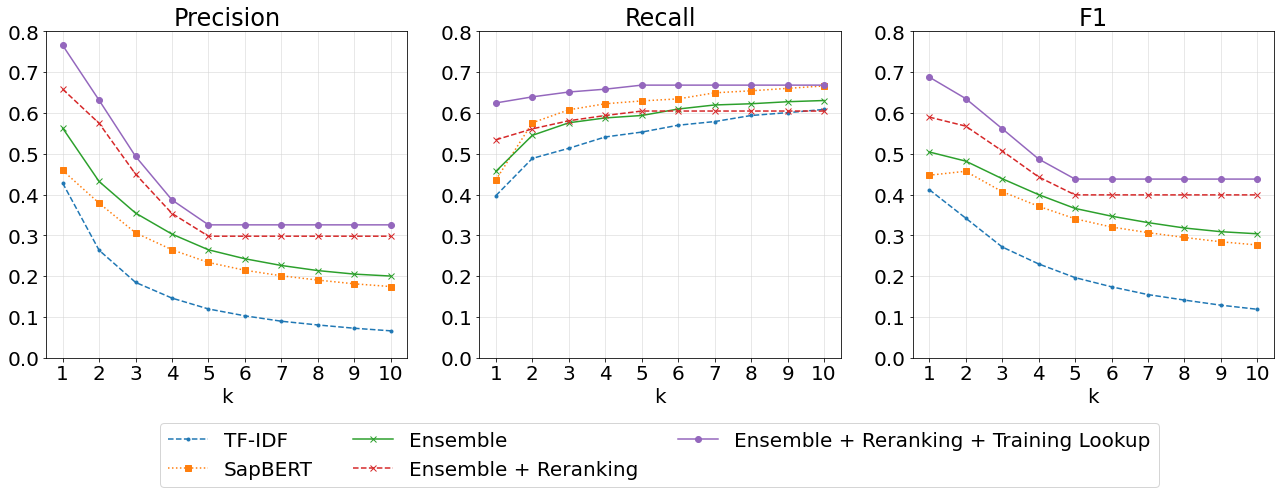

In [31]:
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1, 3, figsize=(22,6))

for j, key in enumerate(['p', 'r', 'f1']):
    ax = axs[j]
    cols = [f'{key}@{i}' for i in k_range]
    subset_df = eval_df[cols]
    subset_df.columns = k_range
    subset_df.T.plot(ax=ax, legend=False, style=['.--','s:','x-','x--', 'o-'])
    ax.grid(color='lightgray', linestyle='-', linewidth=0.5)
    ax.set_ylim(0.0,0.8)
    ax.set_xticks(k_range)
    ax_labels = {
        'p' : 'Precision',
        'r' : 'Recall',
        'f1' : 'F1'
    }
    ax.set_title(ax_labels[key])
    ax.set_xlabel('k')
    
handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, 
           ['TF-IDF', 'SapBERT', 'Ensemble', 'Ensemble + Reranking', 'Ensemble + Reranking + Training Lookup'], 
           loc='center',
           ncol=3, bbox_to_anchor=(0.512, -0.1, 0.00, 0.0))

plt.subplots_adjust(wspace=0.20)

plt.xticks(k_range)
plt.savefig('img/scores_at_k.png', dpi=600, bbox_inches='tight')

In [32]:
### Distribution of semantic types

In [33]:
merge_eval_df(out_valid, run_eval(X_valid, out_valid.values(), thresholds=[0.0], ks=[100])[0])

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


,,f1@100,p@100,r@100
linker,threshold,,,
ngrams,0.000,0.017,0.008,0.732
sap_umls,0.000,0.079,0.042,0.780
ensemble,0.000,0.160,0.091,0.674
ensemble_reranked,0.000,0.399,0.298,0.605
ensemble_reranked_post_process,0.000,0.438,0.326,0.668


In [34]:
def type_count(data, name=None, cols=['disorder', 'finding', 'morphologic abnormality']):
    types = []
    for e in data['entities']:
        for c in e['concepts']:
            if len(c['concept_id']) > 0:
                types.append(get_type(c['concept_id'][0]))
            #else:
            #    types.append('None')
    s = pd.Series(types).value_counts() / pd.Series(types).value_counts().sum()
    s.name=name
    #if not 'None' in s:
    #    s['None'] = 0
    s['Others'] = s[[i for i in s.index if i not in cols]].sum()
    return s.loc[cols + ['Others']]

In [35]:
type_count(out_valid['ensemble'], 'Ensemble')

disorder                  0.750
finding                   0.081
morphologic abnormality   0.148
Others                    0.021
Name: Ensemble, dtype: float64

In [36]:
type_count(X_valid, 'Ground Truth')

disorder                  0.856
finding                   0.096
morphologic abnormality   0.037
Others                    0.012
Name: Ground Truth, dtype: float64

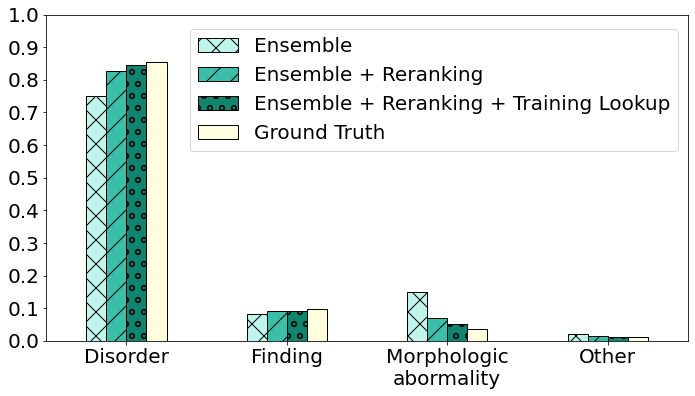

In [37]:
fig, ax = plt.subplots(1,1, figsize=(11.5,6))
ax = pd.concat([
    type_count(out_valid['ensemble'], 'Ensemble'),
    type_count(out_valid['ensemble_reranked'], 'Ensemble + Reranking'),
    type_count(out_valid['ensemble_reranked_post_process'], 'Ensemble + Reranking + Training Lookup'),
    type_count(X_valid, 'Ground Truth'),
], axis=1).plot.bar(color=['#C0F5EC', '#3CBFA9', '#118470', 'lightyellow'], edgecolor='black', ax=ax, legend=False)
ax.set_xticklabels(['Disorder', 'Finding', 'Morphologic\nabormality', 'Other'])
plt.yticks(np.arange(0.0, 1.01, 0.1))
plt.xticks(rotation=0)

hatches = ["x", "/", "o", ""]

handles, labels = ax.get_legend_handles_labels()

for i, h in enumerate(handles):
    for p in h.patches:
        p.set_hatch(hatches[i])

fig.legend(handles, labels, bbox_to_anchor=(0.9,0.87))

for i, p in enumerate(ax.patches):
    p.set_hatch(hatches[int(i/4)])

plt.savefig('img/type_distribution.png', dpi=600)

# Submission Run

## Training Set

In [38]:
scores, predictions = run_all_linkers(X)

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-38c19da92ef9f593.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-38c19da92ef9f593.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 4180 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:02<?, ?it/s]


  0%|          | 0/466 [00:00<?, ?ex/s]

  0%|          | 0/466 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-38c19da92ef9f593.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-38c19da92ef9f593.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-38c19da92ef9f593.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 4180 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:02<?, ?it/s]


  0%|          | 0/466 [00:00<?, ?ex/s]

  0%|          | 0/466 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-38c19da92ef9f593.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble (reranked)

Done !


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble (reranked) post processed

Done !


In [39]:
scores

,p_loose,r_loose,f1_loose,p_strict,r_strict,f1_strict
name,,,,,,
n-grams (DisTEMIST),0.490,0.465,0.477,0.490,0.463,0.476
sapBERT (DisTEMIST + UMLS),0.477,0.458,0.467,0.477,0.456,0.466
Ensemble,0.591,0.495,0.539,0.590,0.493,0.537
Ensemble + Reranking,0.667,0.560,0.609,0.667,0.558,0.608
Ensemble + Reranking + Post-Processing,1.000,0.958,0.978,1.000,0.957,0.978


## Validation Set (w/ Gold Entities)

In [40]:
scores, predictions = run_all_linkers(X_valid)

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 956 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]


  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 956 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]


  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-4d74224e395865f3.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble (reranked)

Done !


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble (reranked) post processed

Done !


In [41]:
scores

,p_loose,r_loose,f1_loose,p_strict,r_strict,f1_strict
name,,,,,,
n-grams (DisTEMIST),0.428,0.398,0.413,0.428,0.397,0.412
sapBERT (DisTEMIST + UMLS),0.459,0.437,0.448,0.459,0.436,0.447
Ensemble,0.563,0.459,0.506,0.563,0.457,0.504
Ensemble + Reranking,0.659,0.536,0.591,0.659,0.534,0.590
Ensemble + Reranking + Post-Processing,0.766,0.626,0.689,0.766,0.625,0.688


## NER + Linker predictions

In [42]:
def clean_up(entities):
    entities = entities.copy()
    result = {k: [] for k in entities.keys()}
    
    def append(i):
        for k in result.keys():
            result[k].append(entities[k][i])
    
    for i, t in enumerate(entities['text']):
        start = entities['spans_start'][i][0]
        end = entities['spans_end'][i][-1]
        if len(t) == 1:
            continue
        append(i)
        m = re.match(r'([\w\s]*)\W+$', t)
        if m:
            result['text'][-1] = m.group(1)
            result['spans_end'][-1] = [end - len(t) + len(m.group(1))]
            t = m.group(1)
            end = entities['spans_end'][i][-1]
        m = re.match(r'^([^\n]+)\n+.*', t)
        if m:
            result['text'][-1] = m.group(1)
            result['spans_end'][-1] = [end - len(t) + len(m.group(1))]
            t = m.group(1)
            end = entities['spans_end'][i][-1]
    return result

In [43]:
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline

In [44]:
ner_model_path = '../models/model_1'
ner_model_checkpoint = Path(ner_model_path)

model = AutoModelForTokenClassification.from_pretrained(ner_model_checkpoint / 'best_cp')
tokenizer = AutoTokenizer.from_pretrained(ner_model_checkpoint / 'best_cp', add_prefix_space=True)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

from transformers.pipelines.token_classification import AggregationStrategy
ner_pipe = pipeline("ner", model, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)

In [45]:
all_training_texts = distemist_util.load_distemist_texts('../data/distemist/training/text_files', sort_keys=False)

In [46]:
X

Dataset({
    features: ['corpus_id', 'document_id', 'doctype', 'lang', 'unit_id', 'source_unit_id', 'text', 'entities'],
    num_rows: 466
})

In [47]:
pred_ner_full = distemist_util.run_ner_pipeline(X, ner_pipe).map(lambda row: {'entities' : clean_up(row['entities'])})

#Show be very close to 1
print(evaluate(X, pred_ner_full, ner_only=True)['ner_strict'])
print(evaluate(X, pred_ner_full, ner_only=True)['ner_partial'])

/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/transformers/pipelines/token_classification.py:291: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn("Tokenizer does not support real words, using fallback heuristic", UserWarning)
/mnt/nfs/home/Florian.Borchert/workspace/distemist_bioasq_2022/notebooks/../scripts/distemist_util.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(pipeline([s.text for s in spacy_sents]))


  0%|          | 0/466 [00:00<?, ?ex/s]

/mnt/nfs/home/Florian.Borchert/workspace/distemist_bioasq_2022/notebooks/../scripts/distemist_util.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents = np.array(spacy_sents)[np.array(idx) == i].ravel()


  0%|          | 0/466 [00:00<?, ?ex/s]

{'precision': 0.9845360824742269, 'recall': 0.9595693779904306, 'fscore': 0.9718924157984008, 'ptp': 4011, 'fp': 63, 'rtp': 4011, 'fn': 169, 'n_docs_system': 466, 'n_annos_system': 0, 'n_docs_gold': 466, 'n_annos_gold': 0}
{'precision': 0.9987728520917539, 'recall': 0.9849879624847333, 'fscore': 0.991832512607574, 'ptp': 4069.0005994218054, 'fp': 4.999400578194582, 'rtp': 4117.249683186185, 'fn': 62.75031681381461, 'n_docs_system': 466, 'n_annos_system': 0, 'n_docs_gold': 466, 'n_annos_gold': 0}


In [48]:
scores, train_predictions = run_all_linkers(pred_ner_full, ground_truth=X)

  0%|          | 0/466 [00:00<?, ?ex/s]

  0%|          | 0/466 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-1d2163537f0b1487.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 4074 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:02<?, ?it/s]


  0%|          | 0/466 [00:00<?, ?ex/s]

  0%|          | 0/466 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-1d2163537f0b1487.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-1d2163537f0b1487.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-1d2163537f0b1487.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 4074 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:02<?, ?it/s]


  0%|          | 0/466 [00:00<?, ?ex/s]

  0%|          | 0/466 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-1d2163537f0b1487.arrow


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble (reranked)

Done !


  0%|          | 0/466 [00:00<?, ?ex/s]

>>> Ensemble (reranked) post processed

Done !


In [49]:
# Should be very similar to training w/ gold entities
scores

,p_loose,r_loose,f1_loose,p_strict,r_strict,f1_strict
name,,,,,,
n-grams (DisTEMIST),0.488,0.454,0.471,0.485,0.448,0.466
sapBERT (DisTEMIST + UMLS),0.472,0.442,0.457,0.470,0.439,0.454
Ensemble,0.586,0.477,0.526,0.582,0.474,0.522
Ensemble + Reranking,0.664,0.542,0.597,0.661,0.538,0.593
Ensemble + Reranking + Post-Processing,0.990,0.923,0.955,0.987,0.918,0.951


## Validation Set (w/o Gold Entities)

In [50]:
pred_ner_valid = distemist_util.run_ner_pipeline(X_valid, ner_pipe).map(lambda row: {'entities' : clean_up(row['entities'])})

# Should be around .75 -> .76 for clean up!!
print(evaluate(X_valid, pred_ner_valid, ner_only=True)['ner_strict'])
print(evaluate(X_valid, pred_ner_valid, ner_only=True)['ner_partial'])

/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/transformers/pipelines/token_classification.py:291: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn("Tokenizer does not support real words, using fallback heuristic", UserWarning)
/mnt/nfs/home/Florian.Borchert/workspace/distemist_bioasq_2022/notebooks/../scripts/distemist_util.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(pipeline([s.text for s in spacy_sents]))


  0%|          | 0/117 [00:00<?, ?ex/s]

/mnt/nfs/home/Florian.Borchert/workspace/distemist_bioasq_2022/notebooks/../scripts/distemist_util.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents = np.array(spacy_sents)[np.array(idx) == i].ravel()


  0%|          | 0/117 [00:00<?, ?ex/s]

{'precision': 0.7564234326824255, 'recall': 0.7698744769874477, 'fscore': 0.7630896837739761, 'ptp': 736, 'fp': 237, 'rtp': 736, 'fn': 220, 'n_docs_system': 117, 'n_annos_system': 0, 'n_docs_gold': 117, 'n_annos_gold': 0}
{'precision': 0.8639885318513207, 'recall': 0.8775996152323885, 'fscore': 0.8707408859983137, 'ptp': 840.6608414913351, 'fp': 132.33915850866492, 'rtp': 838.9852321621634, 'fn': 117.01476783783664, 'n_docs_system': 117, 'n_annos_system': 0, 'n_docs_gold': 117, 'n_annos_gold': 0}


In [51]:
scores, valid_predictions = run_all_linkers(pred_ner_valid, ground_truth=X_valid)

  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-afca0874320e1ff1.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 973 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]


  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-afca0874320e1ff1.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-afca0874320e1ff1.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-afca0874320e1ff1.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Calculate embeddings for 973 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]


  0%|          | 0/117 [00:00<?, ?ex/s]

  0%|          | 0/117 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/dis_temist/subtrack2_linking/3.0.1/a1915148dbf2c746ae734644cb098356da71f63ed6fa586d9b24ac3cfb42df01/cache-afca0874320e1ff1.arrow


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble (reranked)

Done !


  0%|          | 0/117 [00:00<?, ?ex/s]

>>> Ensemble (reranked) post processed

Done !


In [52]:
scores

,p_loose,r_loose,f1_loose,p_strict,r_strict,f1_strict
name,,,,,,
n-grams (DisTEMIST),0.369,0.350,0.359,0.339,0.322,0.330
sapBERT (DisTEMIST + UMLS),0.395,0.381,0.388,0.367,0.355,0.361
Ensemble,0.481,0.398,0.435,0.447,0.374,0.408
Ensemble + Reranking,0.566,0.470,0.513,0.529,0.443,0.482
Ensemble + Reranking + Post-Processing,0.653,0.544,0.593,0.617,0.517,0.563


## Test Set

In [56]:
out_file_base = Path('../submission') / 'subtrack2_linking'

In [57]:
all_test_texts = distemist_util.load_distemist_texts('../data/distemist/test_background/text_files', sort_keys=True)
all_test_pred_ner = distemist_util.run_ner_pipeline(all_test_texts, ner_pipe).map(lambda row: {'entities' : clean_up(row['entities'])})

/home/Florian.Borchert/.cache/pypoetry/virtualenvs/xl-bel-TMSi1vFk-py3.8/lib/python3.8/site-packages/transformers/pipelines/token_classification.py:291: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn("Tokenizer does not support real words, using fallback heuristic", UserWarning)
/mnt/nfs/home/Florian.Borchert/workspace/distemist_bioasq_2022/notebooks/../scripts/distemist_util.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(pipeline([s.text for s in spacy_sents]))


  0%|          | 0/3000 [00:00<?, ?ex/s]

/mnt/nfs/home/Florian.Borchert/workspace/distemist_bioasq_2022/notebooks/../scripts/distemist_util.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents = np.array(spacy_sents)[np.array(idx) == i].ravel()


  0%|          | 0/3000 [00:00<?, ?ex/s]

In [58]:
_, test_predictions = run_all_linkers(all_test_pred_ner, ground_truth=X_valid) #Just putting in some dataset, the scores don't matter

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Calculate embeddings for 10853 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 10054 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 10432 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 10459 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 6946 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:01<?, ?it/s]


  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

ngrams
Loading XL model
Loading embeddings
Loading dict


  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Calculate embeddings for 10853 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 10054 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 10432 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 10459 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
Calculate embeddings for 6946 mentions
Calculating score matrix
Retrieving 100 candidates on GPU
sap_umls


  0%|                                                                                             | 0/2 [00:01<?, ?it/s]


  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/3000 [00:00<?, ?ex/s]

>>> Ensemble


  0%|          | 0/3000 [00:00<?, ?ex/s]

>>> Ensemble (reranked)

Done !


  0%|          | 0/3000 [00:00<?, ?ex/s]

>>> Ensemble (reranked) post processed

Done !


In [59]:
file_names = {
    'ngrams' : '1-tf_idf_ngrams_distemist.tsv',
    'sap_umls' : '2-sap_umls_large_distemist.tsv',
    'ensemble' : '3-ensemble.tsv',
    'ensemble_reranked' : '4-ensemble-reranking.tsv',
    'ensemble_reranked_post_process' : '5-ensemble-reranking-postprocess.tsv',
}

for k, file_name in file_names.items():
    distemist_util.write_dataset_to_tsv(test_predictions[k], out_file_base / file_name, concepts=True, write_missing_concepts=True)